In [ ]:

import pulp as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the optimization model
model = pl.LpProblem("Cutting_Stock_Problem", pl.LpMinimize)

# Parameters
stock_length = 100  # Length of raw material stock
item_lengths = [45,36,31,passp]  # Lengths of items to be cut
demands = [97,610,395,211]  # Number of each item needed
     

In [2]:
# Generate all feasible cutting patterns
def generate_patterns(stock_length, item_lengths):
    """Generate all feasible cutting patterns"""
    patterns = []

    def backtrack(remaining_length, current_pattern, start_idx):
        patterns.append(current_pattern[:])

        for i in range(start_idx, len(item_lengths)):
            if remaining_length >= item_lengths[i]:
                current_pattern[i] += 1
                backtrack(remaining_length - item_lengths[i], current_pattern, i)
                current_pattern[i] -= 1

    backtrack(stock_length, [0] * len(item_lengths), 0)

    return patterns

all_patterns = generate_patterns(stock_length, item_lengths)


     

In [3]:
print(len(all_patterns), "patterns generated.")

38 patterns generated.


In [4]:
# Filter out patterns that are too wasteful (optional)
max_waste = 14  # Maximum acceptable waste
filtered_patterns = []
for pattern in all_patterns:
    used_length = sum(pattern[i] * item_lengths[i] for i in range(len(item_lengths)))
    waste = stock_length - used_length
    if waste <= max_waste:
        filtered_patterns.append(pattern)

patterns = filtered_patterns
patterns

[[2, 0, 0, 0],
 [1, 1, 0, 1],
 [1, 0, 1, 1],
 [1, 0, 0, 3],
 [0, 2, 0, 1],
 [0, 2, 0, 2],
 [0, 1, 2, 0],
 [0, 1, 1, 2],
 [0, 1, 0, 4],
 [0, 0, 3, 0],
 [0, 0, 2, 2],
 [0, 0, 1, 4],
 [0, 0, 0, 7]]

In [5]:
# Create decision variables - how many times to use each pattern
x = {}
for j in range(len(patterns)):
    x[j] = pl.LpVariable(f"Pattern_{j}", lowBound=0, cat='Integer')

# Objective function - minimize number of stock pieces used
model += pl.lpSum([x[j] for j in range(len(patterns))]), "Minimize_Stock_Used"

# Constraints - meet demand for each item
for i in range(len(item_lengths)):
    model += pl.lpSum([patterns[j][i] * x[j] for j in range(len(patterns))]) >= demands[i], f"Meet_Demand_{i}"
     

In [4]:

# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total stock pieces needed: {pl.value(model.objective)}")

# Get the solution
pattern_counts = []
for j in range(len(patterns)):
    count = x[j].value()
    if count > 0:
        print(f"Pattern {j}: {patterns[j]} used {count} times")
        pattern_counts.append((patterns[j], count))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/musel/Documents/github/cutting-stock/.venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/bf2c724b40b3493fa233b144d60c05ad-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/bf2c724b40b3493fa233b144d60c05ad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 74 RHS
At line 80 BOUNDS
At line 94 ENDATA
Problem MODEL has 5 rows, 13 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 57.5 - 0.00 seconds
Cgl0003I 0 fixed, 13 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 5 rows, 13 columns (13 integer (0 of which binary)) and 24 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 58 found by greedy cover after 0 iterations and 0 nodes (0.00 second

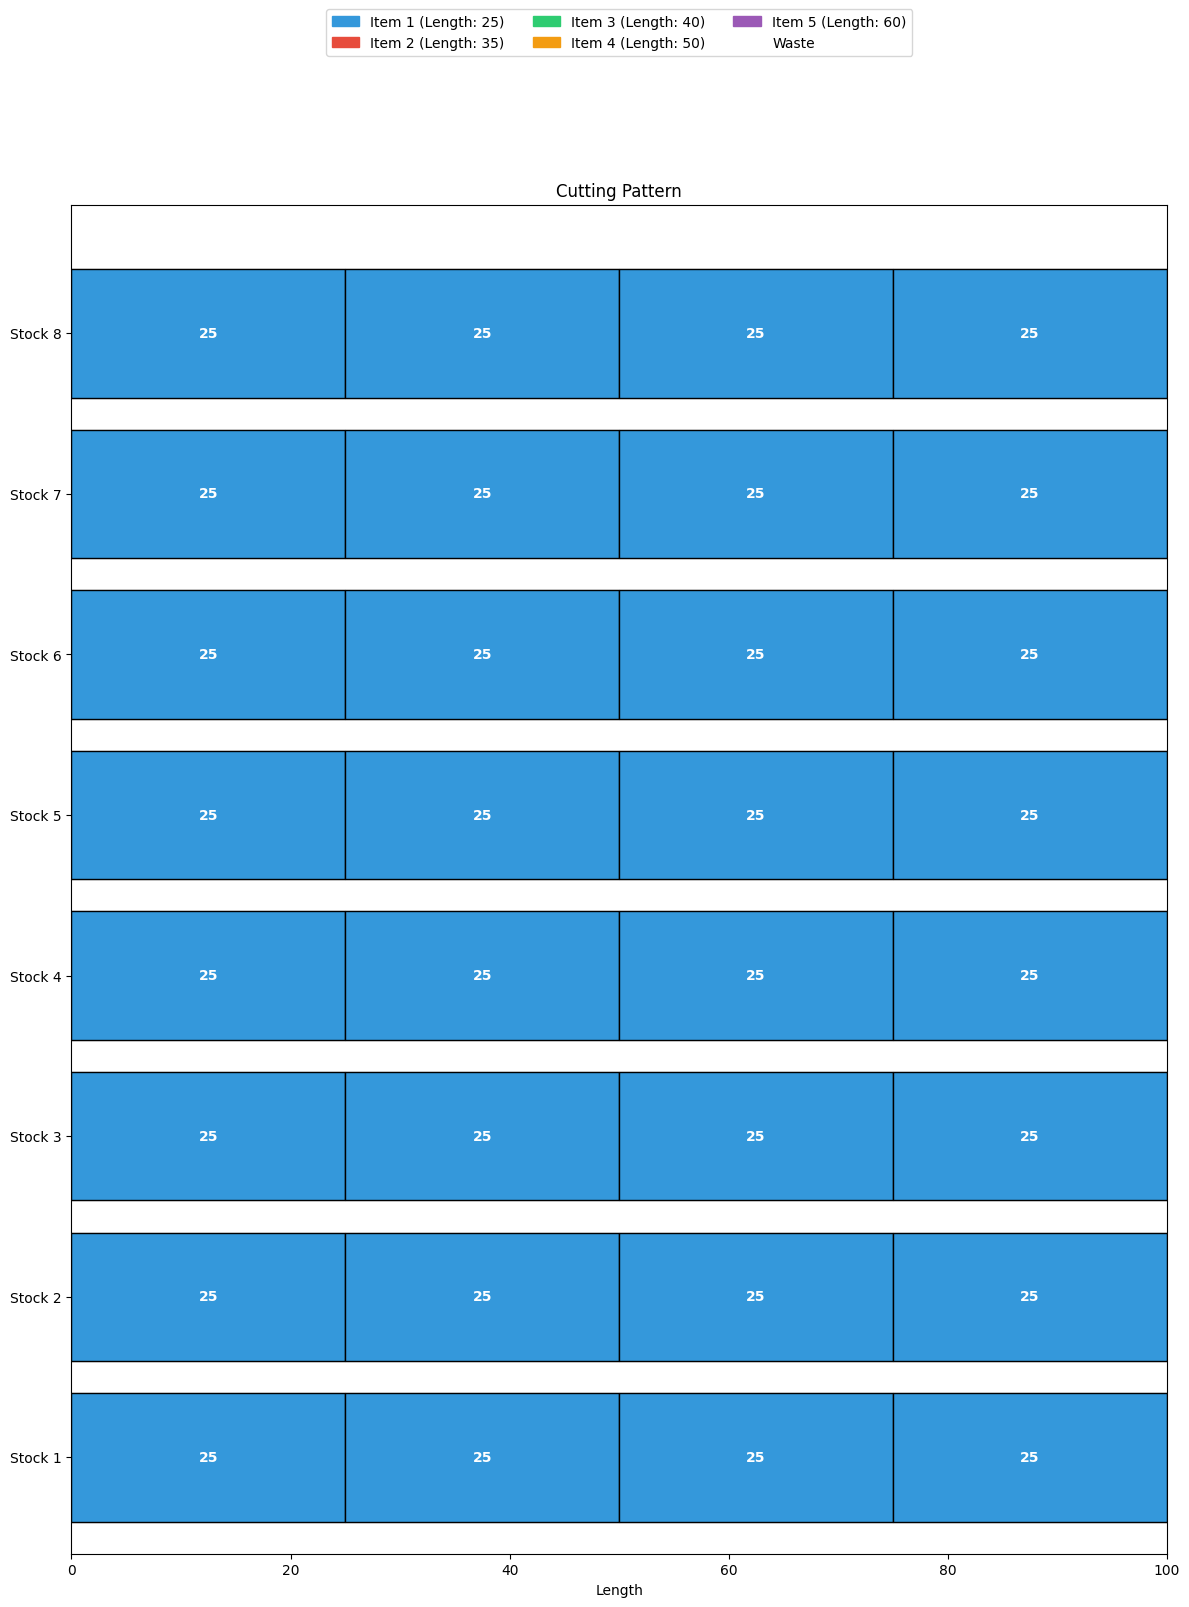

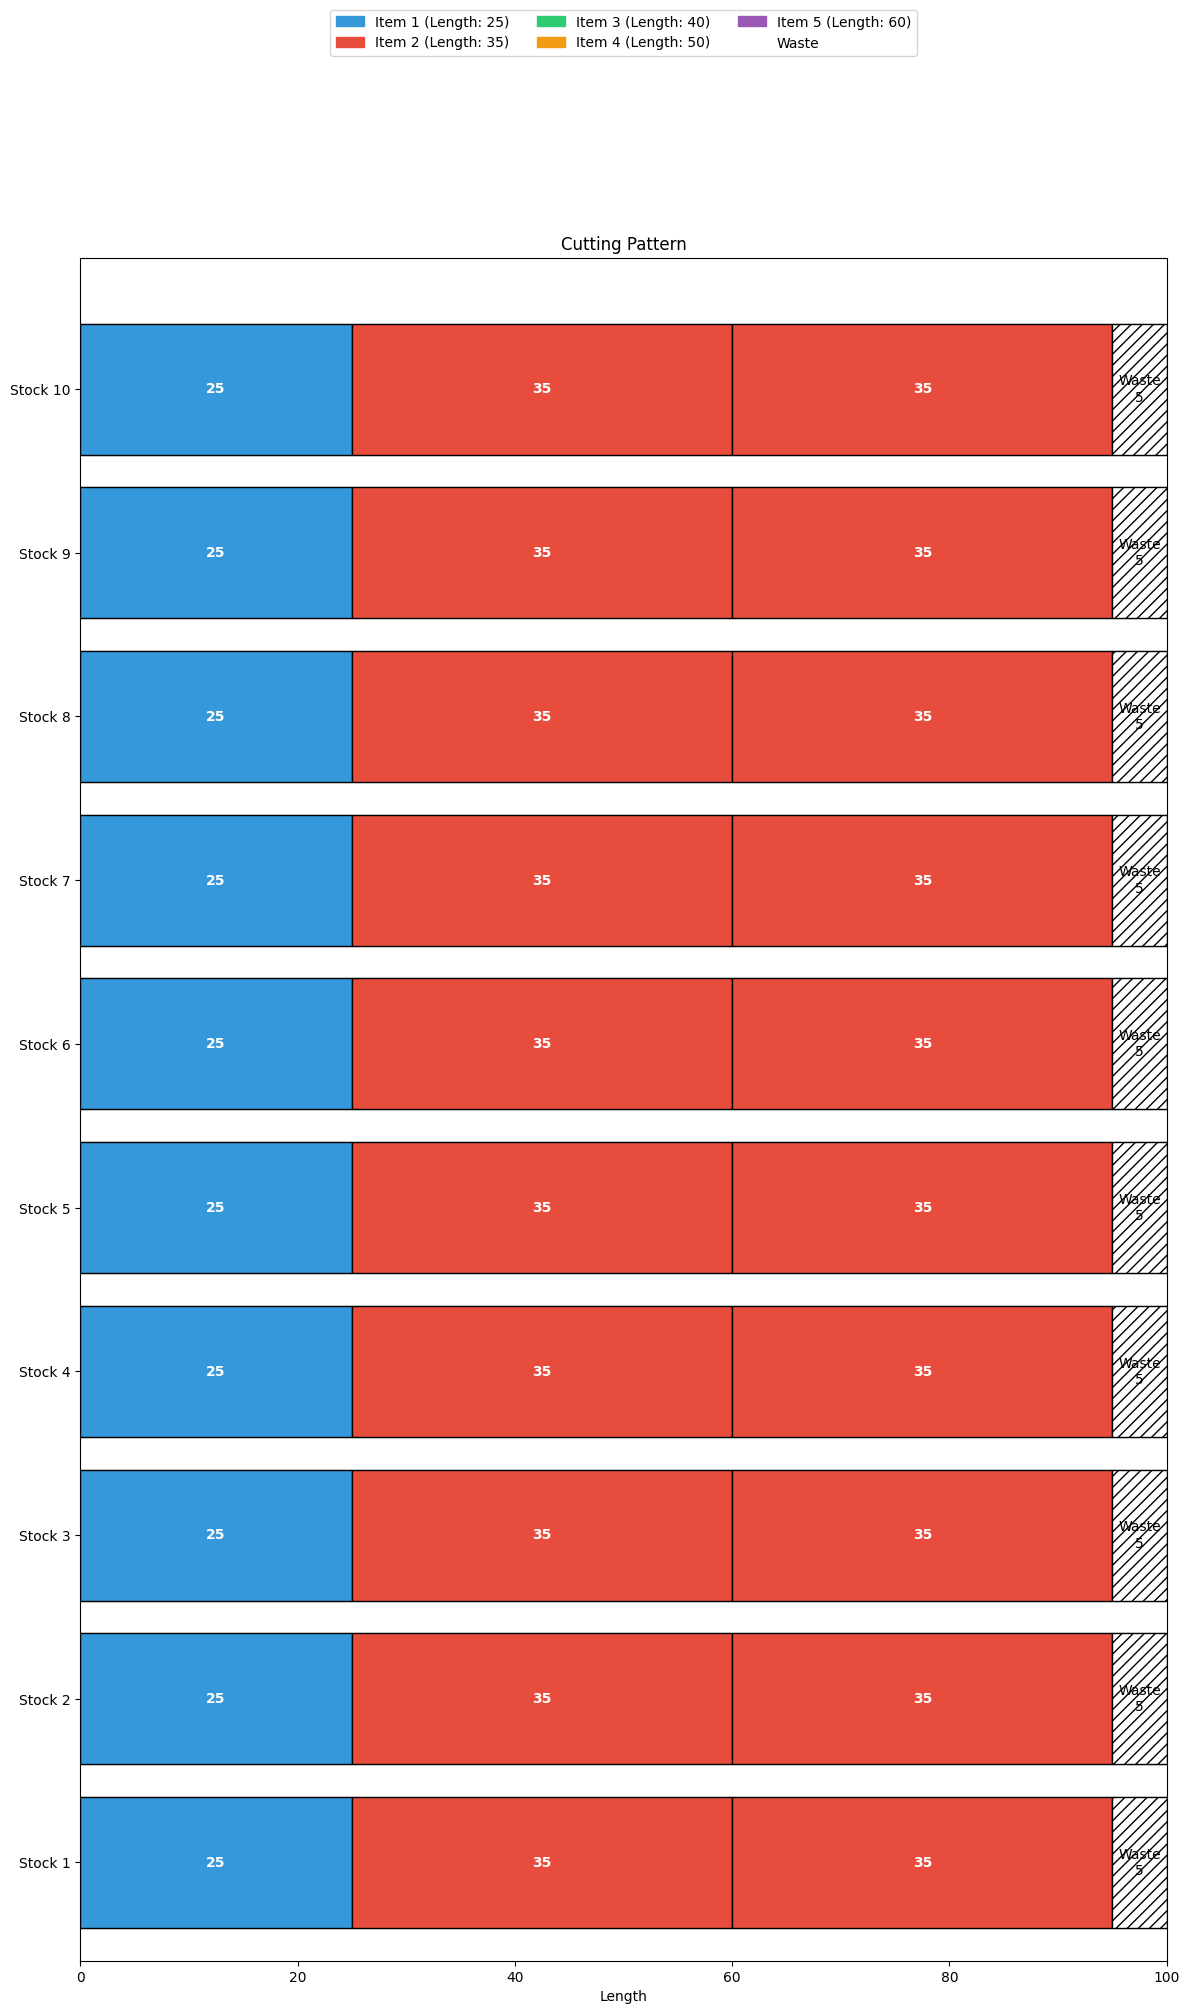

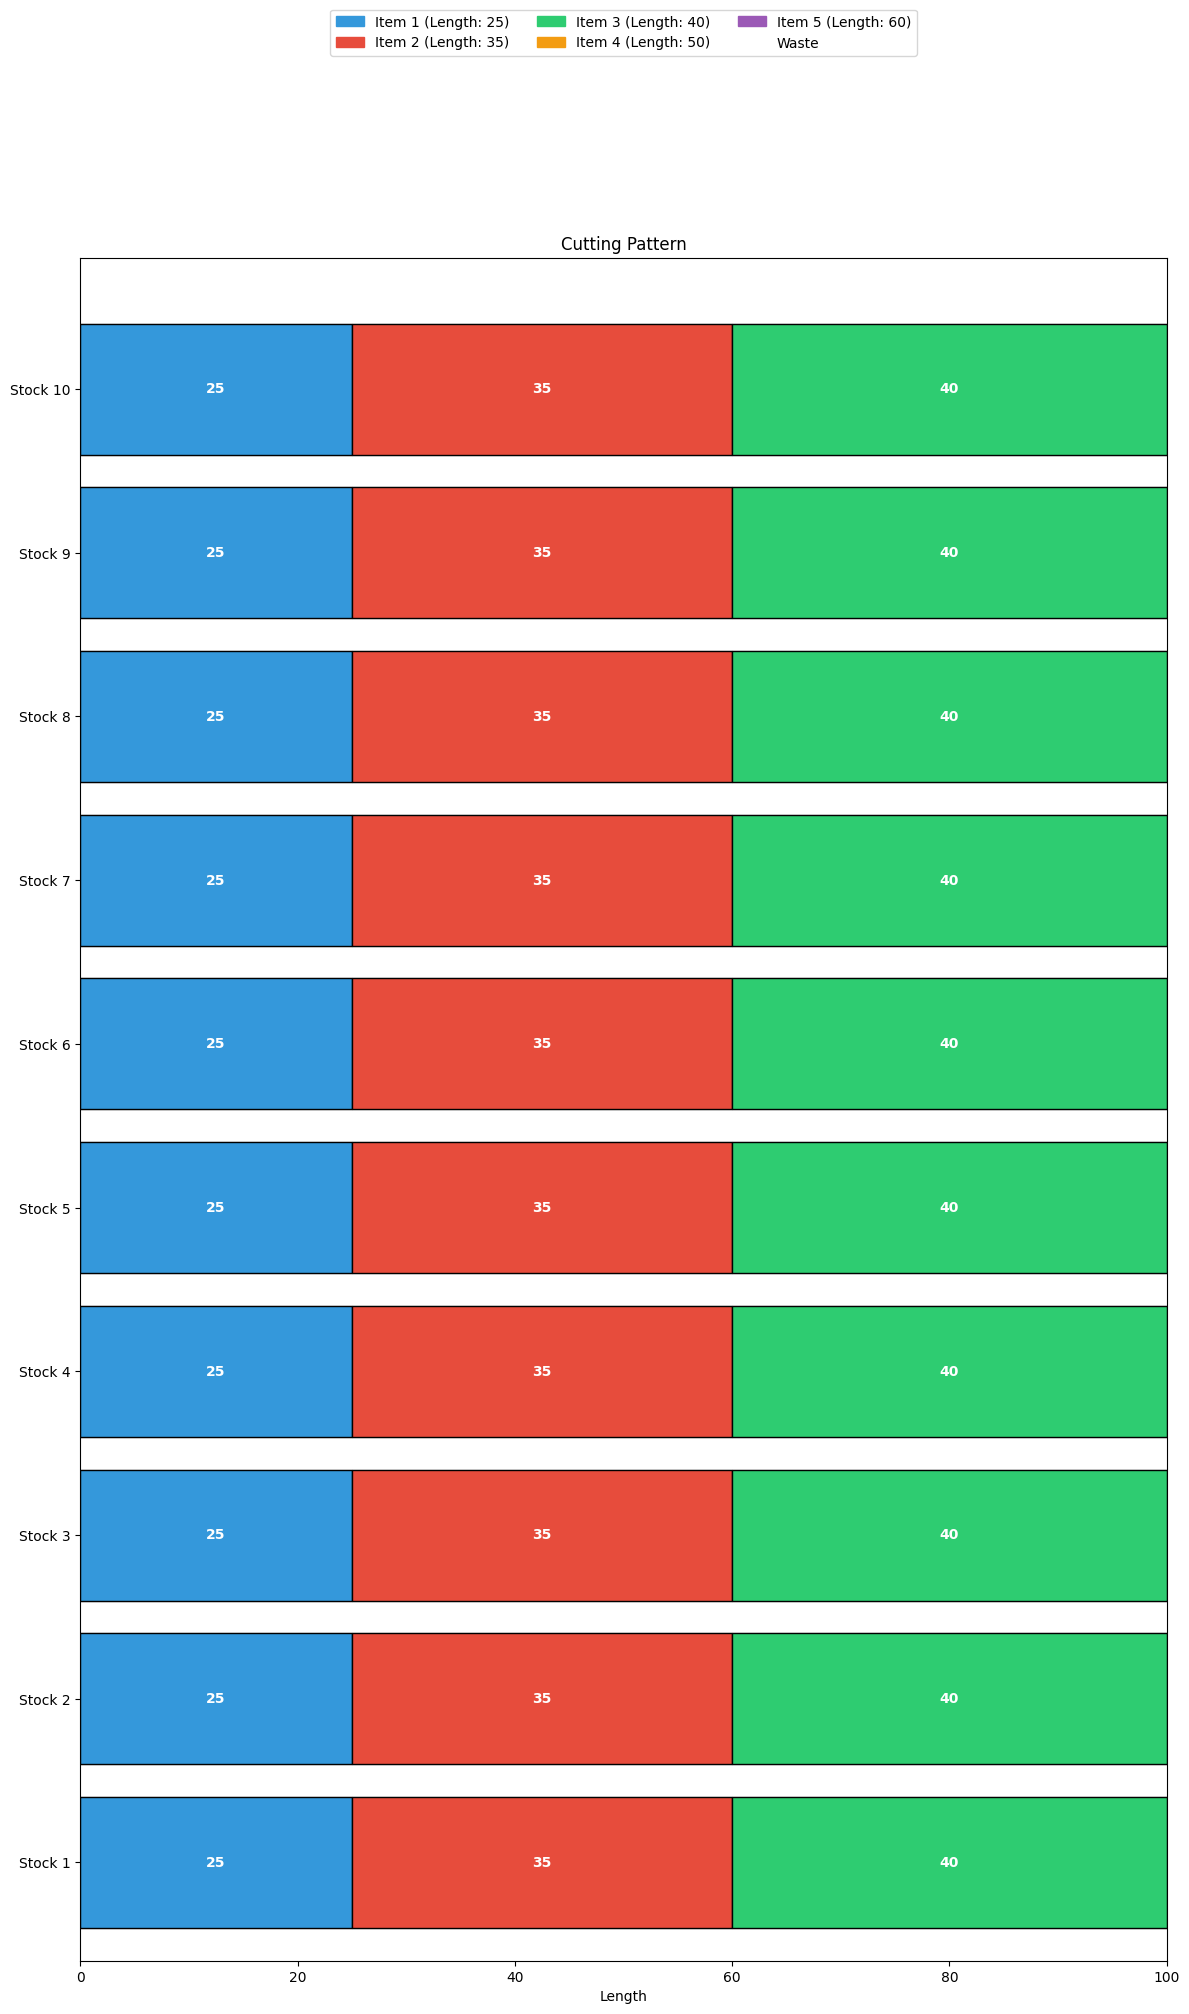

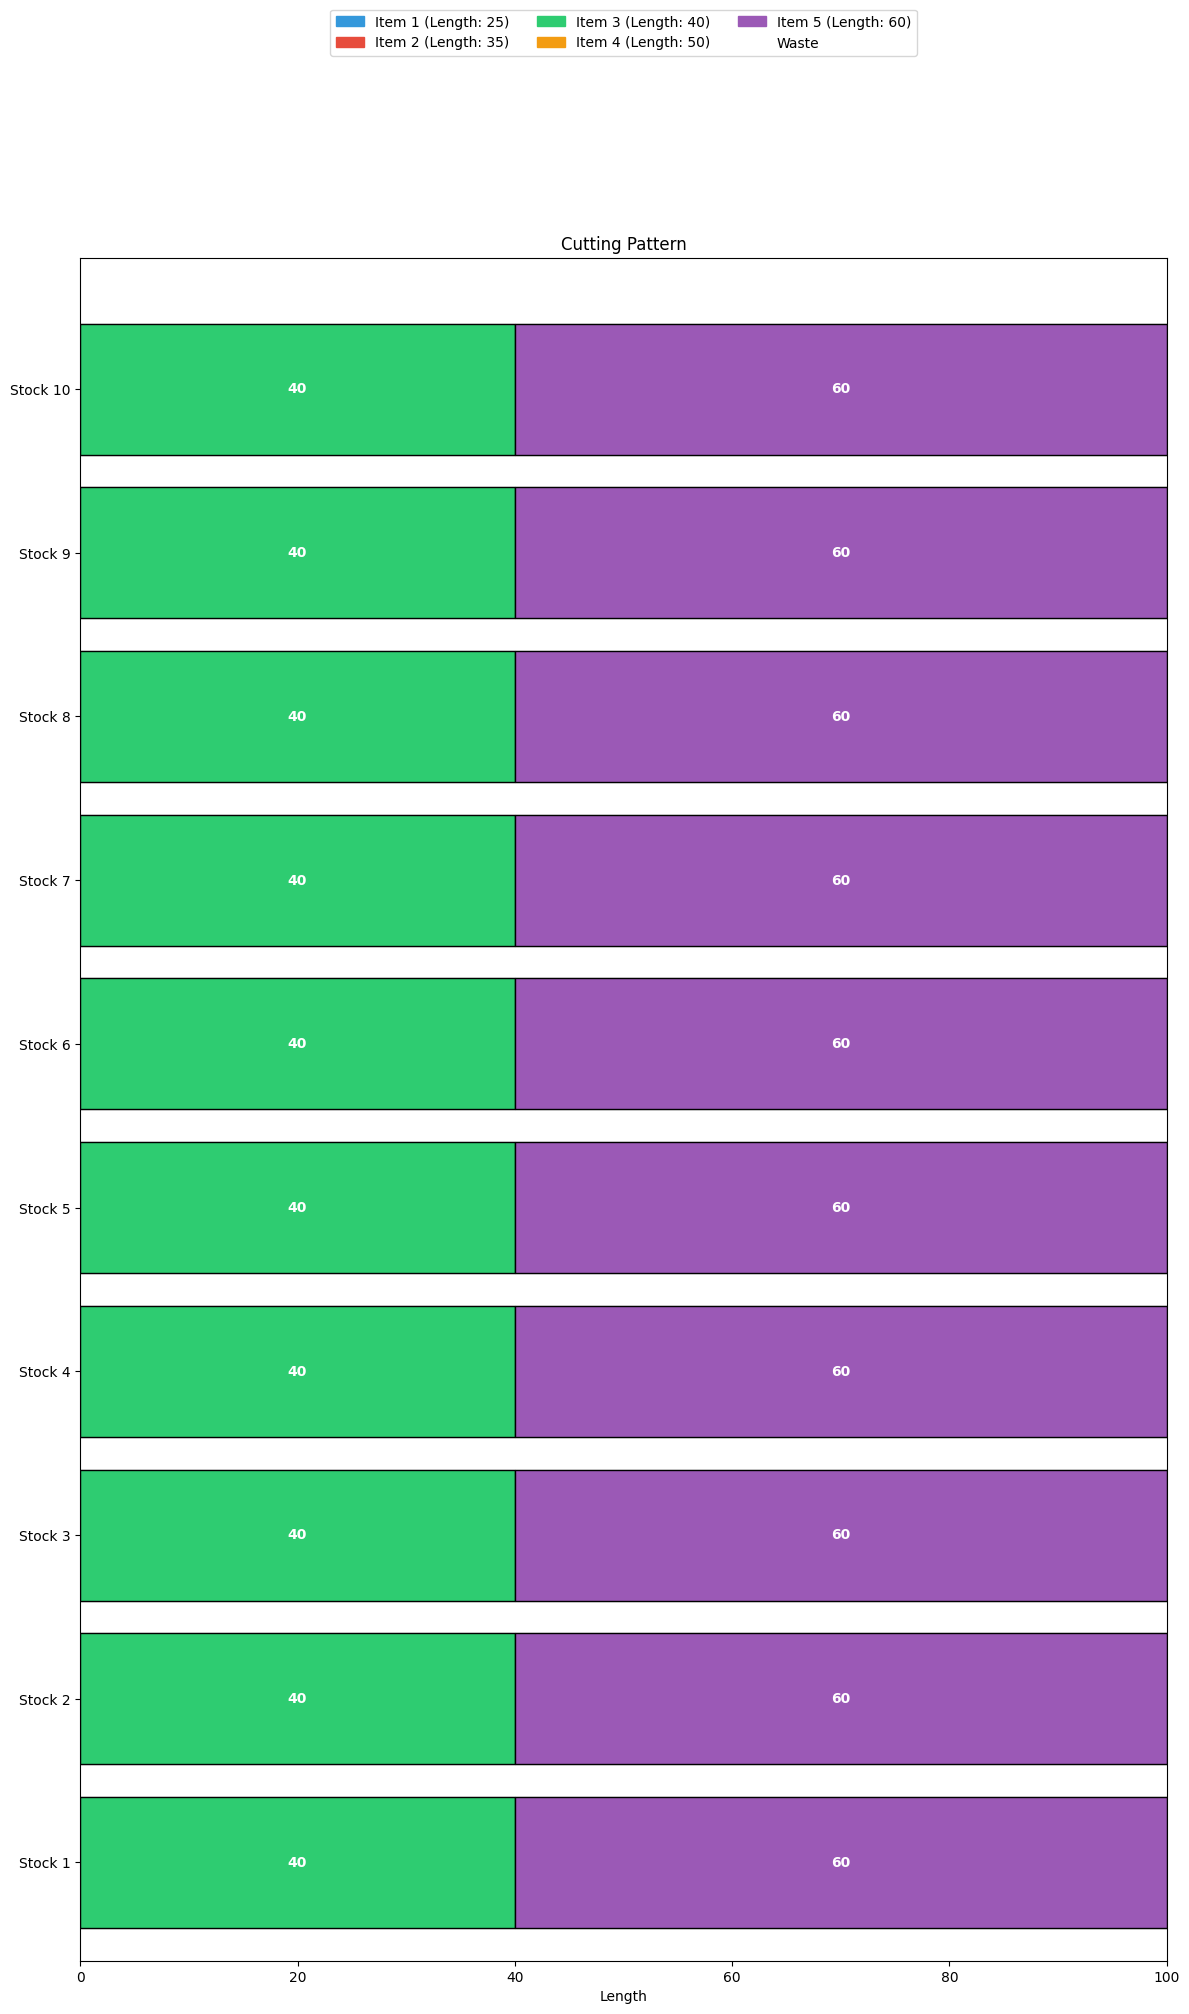

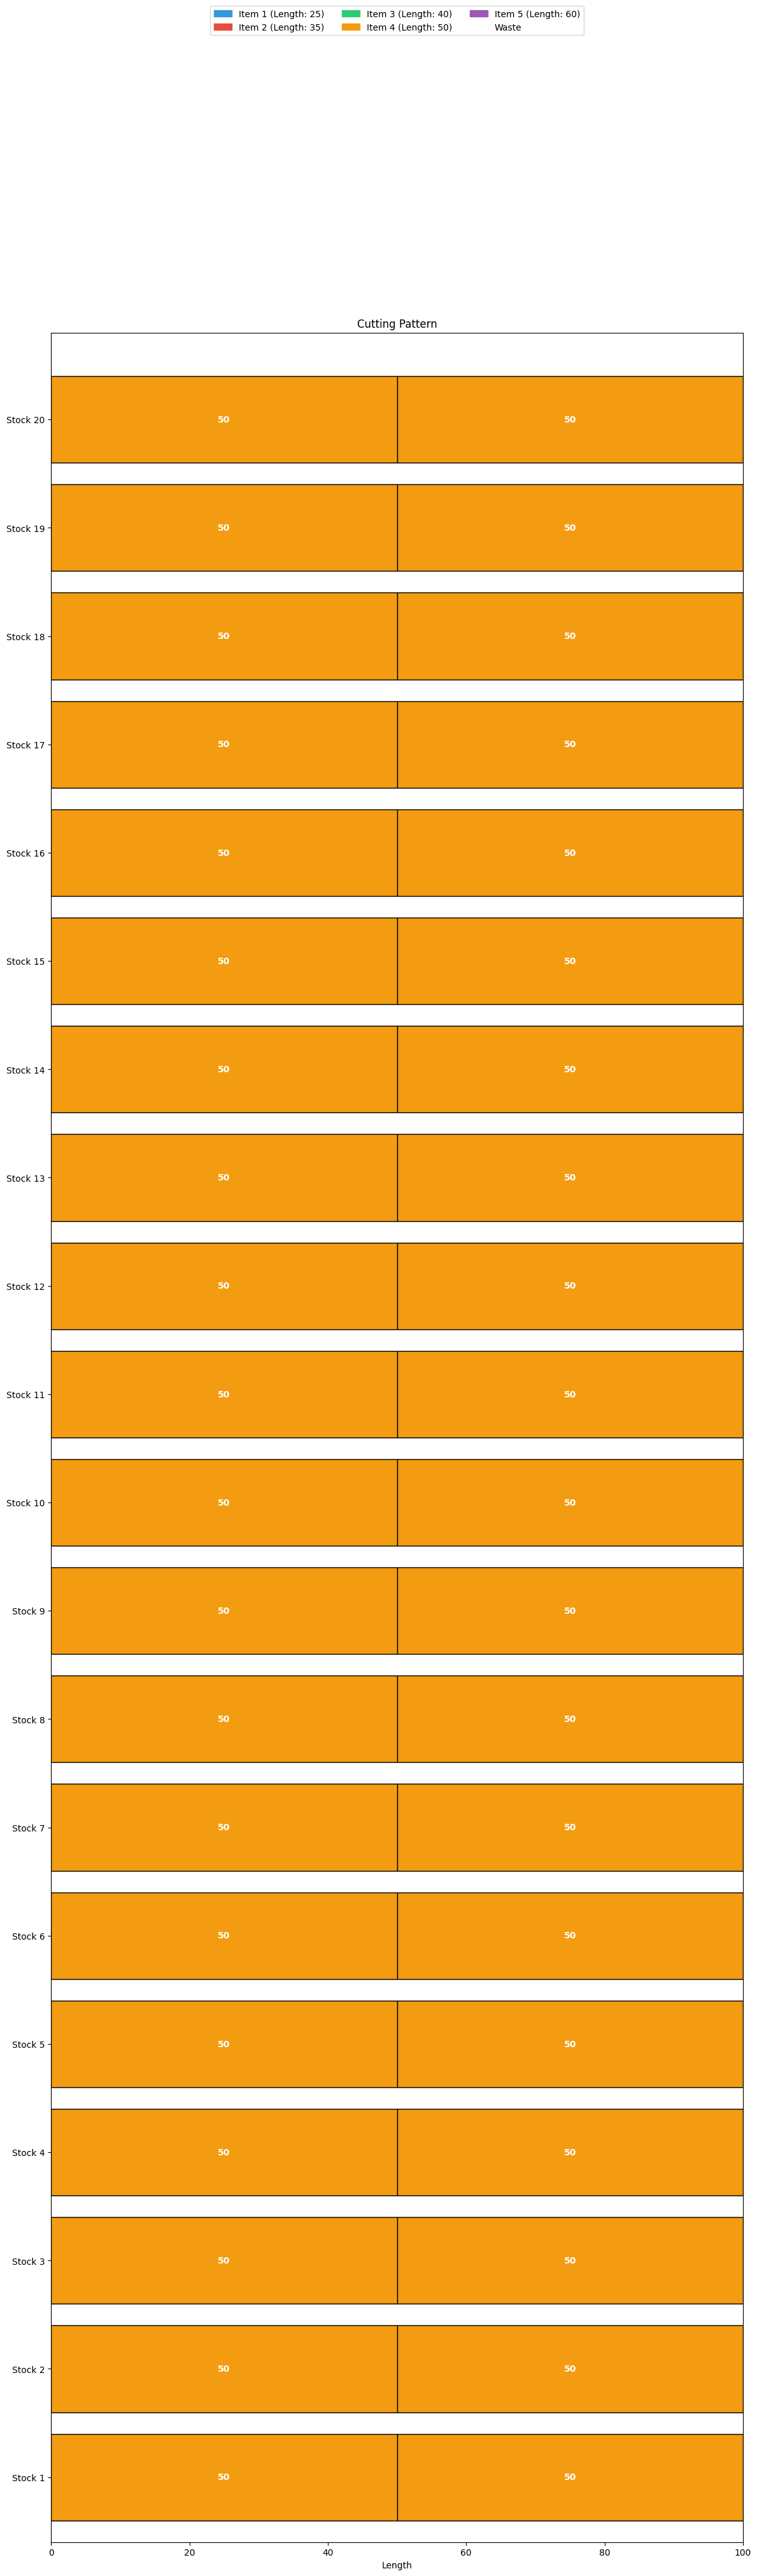

In [5]:
# Visualize the cutting patterns
def visualize_cutting_pattern(pattern, count, stock_length, item_lengths):
    item_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#d35400']

    fig, ax = plt.subplots(figsize=(12, 2 * count))

    for i in range(int(count)):
        current_position = 0
        rect = patches.Rectangle((0, i), stock_length, 0.8, linewidth=1, edgecolor='black', facecolor='gray', alpha=0.3)
        ax.add_patch(rect)

        for j, item_count in enumerate(pattern):
            for _ in range(int(item_count)):
                item_length = item_lengths[j]
                rect = patches.Rectangle(
                    (current_position, i), item_length, 0.8,
                    linewidth=1, edgecolor='black', facecolor=item_colors[j % len(item_colors)]
                )
                ax.add_patch(rect)

                # Add text in the middle of each rectangle
                ax.text(
                    current_position + item_length/2, i + 0.4,
                    f"{item_length}",
                    ha='center', va='center', color='white', fontweight='bold'
                )

                current_position += item_length

        # Show waste
        waste = stock_length - sum(pattern[j] * item_lengths[j] for j in range(len(item_lengths)))
        if waste > 0:
            rect = patches.Rectangle(
                (current_position, i), waste, 0.8,
                linewidth=1, edgecolor='black', facecolor='white', hatch='///'
            )
            ax.add_patch(rect)
            ax.text(
                current_position + waste/2, i + 0.4,
                f"Waste\n{waste}",
                ha='center', va='center', color='black'
            )

    # Add a legend
    legend_patches = []
    for i in range(len(item_lengths)):
        legend_patches.append(patches.Patch(
            color=item_colors[i % len(item_colors)],
            label=f"Item {i+1} (Length: {item_lengths[i]})"
        ))
    legend_patches.append(patches.Patch(color='white', hatch='///', label='Waste'))

    ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    ax.set_xlim(0, stock_length)
    ax.set_ylim(-0.2, count + 0.2)
    ax.set_yticks([i + 0.4 for i in range(int(count))])
    ax.set_yticklabels([f"Stock {i+1}" for i in range(int(count))])
    ax.set_xlabel('Length')
    ax.set_title(f'Cutting Pattern')

    return fig, ax

for i, (pattern, count) in enumerate(pattern_counts):
    fig, ax = visualize_cutting_pattern(pattern, count, stock_length, item_lengths)
    plt.tight_layout()
    plt.show()